In [140]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [141]:
# =========================
# 1. Load All Signatures
# =========================
folder_path = "/content/Signatures"

signature_dict = {
    "mohanad": cv2.imread(os.path.join(folder_path, "Mohanad.png"), 0),
    "ali": cv2.imread(os.path.join(folder_path, "Ali.png"), 0)
}

In [142]:
# =========================
# 2. Utility Functions
# =========================
def display(img, title="Image", cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('on')
    plt.show()


def grayscale(img):
    if len(img.shape) == 2:
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def binarization(gray_img):
    """Convert grayscale image to binary (threshold only)"""
    binary = cv2.adaptiveThreshold(
        gray_img, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15, 2
    )
    return binary


def preprocess(binary_img, kernel_size=(3,3)):
    """Remove noise from binary image"""
    kernel = np.ones(kernel_size, np.uint8)
    clean = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
    return clean


def resize_to(img, target_shape):
    h, w = target_shape
    return cv2.resize(img, (w, h))


def extract_features(clean_img):
    contours, _ = cv2.findContours(clean_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("⚠ No contour found.")
        return None

    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    moments = cv2.moments(clean_img)
    hu = cv2.HuMoments(moments).flatten()

    return np.concatenate(([area, perimeter], hu))

In [143]:
# =========================
# 3. Ask User for Name
# =========================
user_name = input("Enter your signature name: ").strip().lower()
original_sign = signature_dict.get(user_name)

if original_sign is None:
    print("❌ Signature not found. Make sure the name is correct.")
else:
    print("✅ Signature found!")

Enter your signature name: ALI
✅ Signature found!


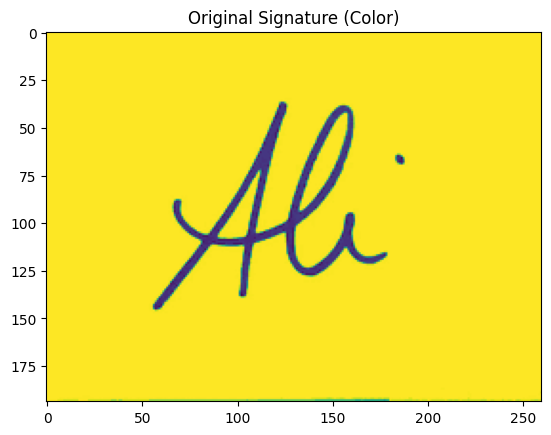

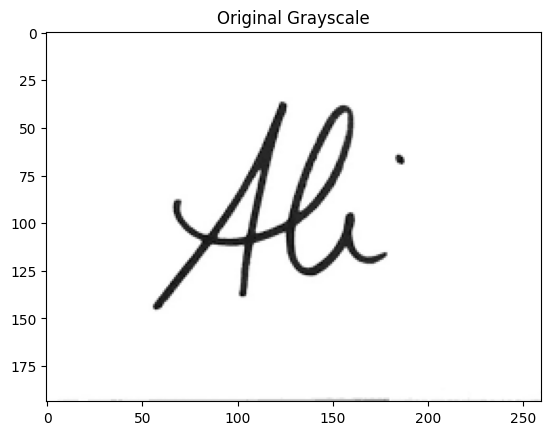

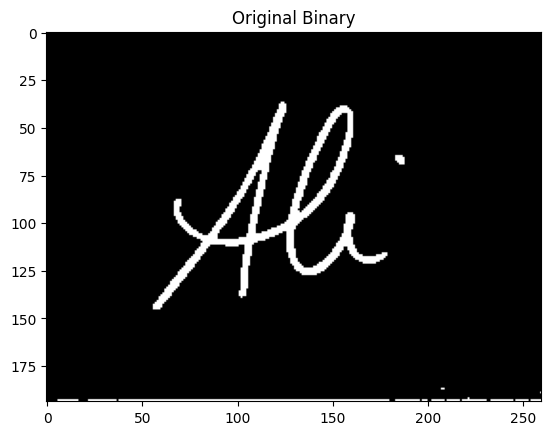

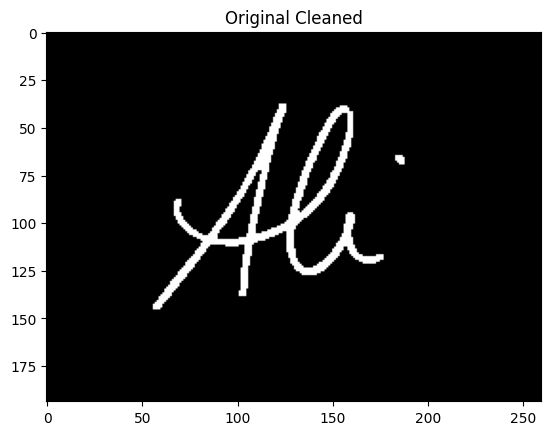

In [ ]:
# =========================
# 4. Preprocess Original Signature
# =========================
original_gray = grayscale(original_sign)
original_binary = binarization(original_gray)
clean_original = preprocess(original_binary)

display(original_sign, "Original Signature (Color)", cmap=None)
display(original_gray, "Original Grayscale")
display(original_binary, "Original Binary")
display(clean_original, "Original Cleaned")


In [145]:
# =========================
# 5. Import User Signature
# =========================
user_path = "/content/Users"
user_file = os.path.join(user_path, f"{user_name.capitalize()}.png")
user_sign = cv2.imread(user_file, 0)

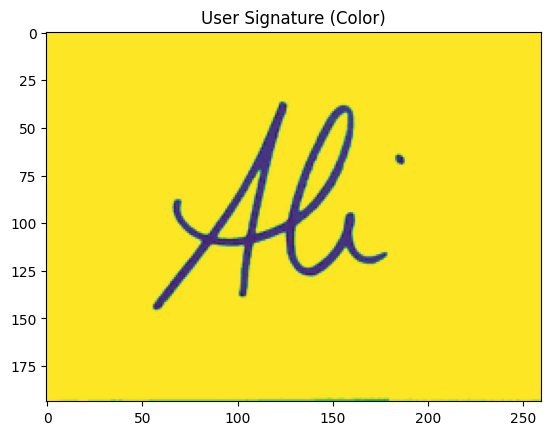

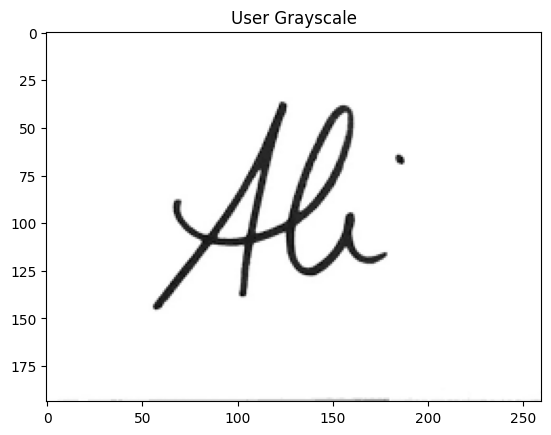

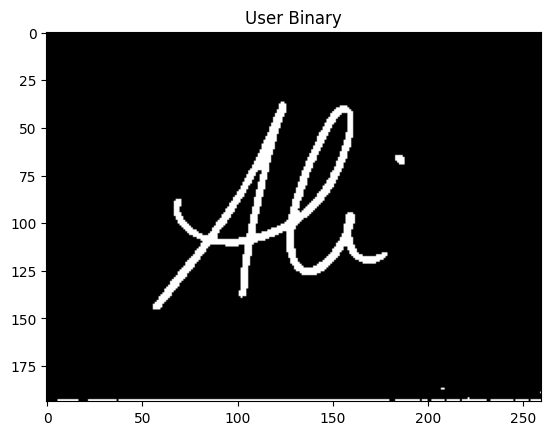

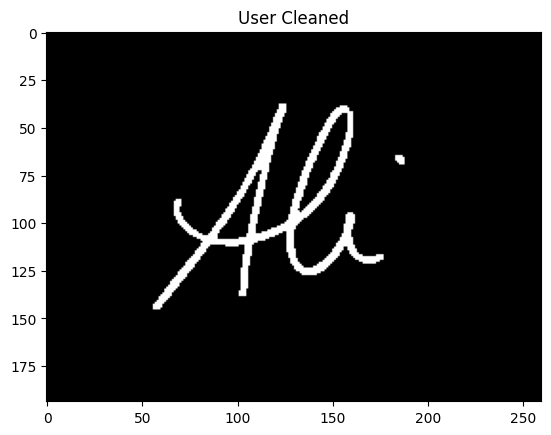

In [146]:
# =========================
# 6. Preprocess User Signature
# =========================
binary_user = binarization(grayscale(user_sign))
user_grey = grayscale(user_sign)
clean_user = preprocess(binary_user)

display(user_sign, "User Signature (Color)", cmap=None)
display(user_grey, "User Grayscale")
display(binary_user, "User Binary")
display(clean_user, "User Cleaned")

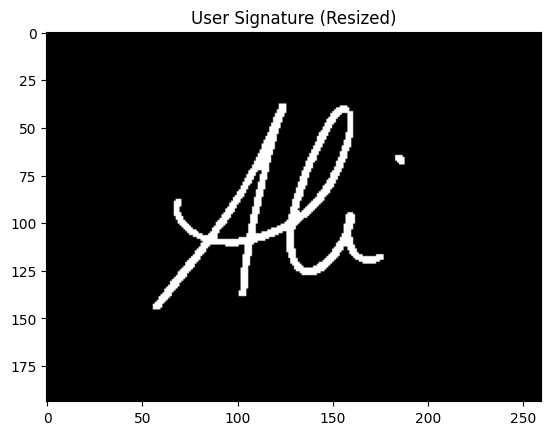

In [147]:
# =========================
# 7. Resize User Signature to Match Original
# =========================
user_resized = resize_to(clean_user, clean_original.shape)
display(user_resized, "User Signature (Resized)")

In [148]:
# =========================
# 8. Compare Signatures Using SSIM
# =========================
similarity = ssim(clean_original, user_resized)
print(f"\nSimilarity Score: {similarity:.3f}")
if similarity >= 1.00:
    print("✅ Signatures Match! (Verified)")
else:
    print("❌ Signatures Do Not Match.")


Similarity Score: 1.000
✅ Signatures Match! (Verified)


In [149]:
# =========================
# 9. Feature-Based Verification
# =========================
f1 = extract_features(clean_original)
f2 = extract_features(user_resized)

if f1 is not None and f2 is not None:
    feature_diff = np.linalg.norm(f1 - f2)
    print(f"\nFeature Difference: {feature_diff:.4f}")
    if feature_diff < 0.5:
        print("✅ Signatures Match (Feature-Based Verification)")
    else:
        print("❌ Signatures Do Not Match (Feature-Based)")
else:
    print("⚠ Feature extraction failed.")


Feature Difference: 0.0000
✅ Signatures Match (Feature-Based Verification)


In [150]:
# =========================
# 10. Verification Function
# =========================
def verify_signature(original_clean, user_clean):
    user_resized = resize_to(user_clean, original_clean.shape)
    ssim_score = ssim(original_clean, user_resized)

    f1 = extract_features(original_clean)
    f2 = extract_features(user_resized)
    feature_diff = np.linalg.norm(f1 - f2) if f1 is not None and f2 is not None else None

    print(f"🔍 SSIM Similarity: {ssim_score:.4f}")
    print(f"📏 Feature Difference: {feature_diff if feature_diff is not None else 'N/A'}")

    SSIM_THRESHOLD = 0.75
    FEATURE_THRESHOLD = 0.5

    print("\n FINAL DECISION:")
    if ssim_score > SSIM_THRESHOLD and feature_diff is not None and feature_diff < FEATURE_THRESHOLD:
        print("✅ RESULT: Signature Verified (Match)")
    elif ssim_score > SSIM_THRESHOLD:
        print("⚠ Partial Match — SSIM OK but features differ")
    elif feature_diff is not None and feature_diff < FEATURE_THRESHOLD:
        print("⚠ Partial Match — Shapes match but SSIM disagrees")
    else:
        print("❌ RESULT: Signature Does NOT Match")

In [151]:
# =========================
# 11. Run Final Verification
# =========================
print("Final Analysis:")
verify_signature(clean_original, clean_user)

Final Analysis:
🔍 SSIM Similarity: 1.0000
📏 Feature Difference: 0.0

 FINAL DECISION:
✅ RESULT: Signature Verified (Match)
